# Using Tensorflow to build a nueral network to segment 60k accelerometer signal into classes

Based on code found on a search taken from:
https://stackoverflow.com/questions/38719091/tensorflow-segmenting-a-signal
It needed some updates to work with newest versions.
Also updated with new get_data() to pull data and masks from csv.

The data needs to be manual albeled.  The file 06 Make Many .... was used for graphs to be manually segmented and labeled.



In [2]:
import tensorflow as tf
from tensorflow.python.platform import flags 
FLAGS = flags.FLAGS
flags.DEFINE_string('train_dir', 'data', 'Directory to put the training data.')
import numpy as np
from skimage import exposure
import os
import matplotlib.pyplot as plt
import random

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [4]:
def bias_variable(shape):
    #initial = tf.constant(0.5, shape=shape)
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [5]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1 ], padding='SAME')

In [6]:
def get_data():
    image_dims = [100]
    np_array_mask = np.zeros(image_dims)
    x = random.sample(range(0,100),2)
    x.sort()
    np_array_mask[x[0]:x[1]]=1.0
    np_array = np_array_mask + np.random.normal(np.zeros(image_dims),0.01)
    return (np_array,np_array_mask)

In [7]:
def training():
    with tf.Session() as sess:
        segment_size = (100,1)
        flat_size = np.prod(segment_size)
        x = tf.placeholder(tf.float32, shape=[None, flat_size])
        y_ = tf.placeholder(tf.float32, shape=[None, flat_size])
        x_shape = [-1] + list(segment_size) + [1]
        x_image = tf.reshape(x, x_shape)
        W_conv1 = weight_variable([7, 1, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

        W_conv2 = weight_variable([7, 1, 32, 32])
        b_conv2 = bias_variable([32])
        h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

        W_fc1 = weight_variable([flat_size*32, flat_size])
        b_fc1 = bias_variable([flat_size])
        h_conv1_flat = tf.reshape(h_conv2, [-1, flat_size*32])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv1_flat, W_fc1) + b_fc1)

        keep_prob = tf.placeholder(tf.float32)
        #h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

        W_fc2 = weight_variable([flat_size, flat_size])
        b_fc2 = bias_variable([flat_size])

        #y_conv=tf.sigmoid(tf.matmul(x, W_fc2) + b_fc2)
        y_conv=tf.sigmoid(tf.matmul(h_fc1, W_fc2) + b_fc2)

        step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            1e-5,   # Base learning rate.
            step,  # Current index into the dataset.
            .01,     # Decay step.
            0.01    # Decay rate
        )

        #opt = tf.train.GradientDescentOptimizer(learning_rate)
        #opt = tf.train.GradientDescentOptimizer(1e-5)
        opt = tf.train.GradientDescentOptimizer(0.5)
        #cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y_conv ,y_))
        cost = tf.reduce_mean(tf.squared_difference(y_, y_conv))
        #cost = tf.reduce_mean(tf.reduce_sum(tf.square(y_-y_conv),reduction_indices=[1]))
        #cost = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_conv)))
        train_op = opt.minimize(cost,global_step=step)
        correct_prediction = tf.div(tf.reduce_sum(tf.mul(y_conv,y_)),tf.reduce_sum(y_conv))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        data = [get_data() for i in range(0,1000)]
        #summary_op = tf.merge_all_summaries()
        #summary_writer = tf.train.SummaryWriter(FLAGS.train_dir, sess.graph)
        sess.run(tf.initialize_all_variables())
        for epoch in range(0,20):
            random.shuffle(data)
            train_data = data[0:500]
            for i in range(100):
                #batch = [exposure.rescale_intensity(vol[1],out_range=(0,1)) for j in range(50*i,50*i+50) for vol in train_data] 
                #batchy = [train_data[i][1] for j in range(50*i, 50*i+50) for vol in train_data ] 
                batch = [exposure.rescale_intensity(vol[0],out_range=(-1,1)) for vol in train_data] 
                batchy = [vol[1] for vol in train_data] 
                feed_dict = {x:batch, y_: batchy, keep_prob: 0.01}
                if i%10 == 0:
                    train_accuracy, cost_val, pred_vals = sess.run([accuracy,cost,y_conv],feed_dict={x:batch, y_: batchy, keep_prob: 1.0})
                    print(cost_val)
                    #print(pred_vals[0],batchy[0])
                    print("step %d, epoch %d training accuracy %g, cost %g "%(i, epoch, train_accuracy, cost_val))
                _, loss_val = sess.run([train_op,cost],feed_dict=feed_dict)
        ind = random.randrange(800,1000)
        test_case = get_data()
        batch = [exposure.rescale_intensity(test_case[0],out_range=(-1,1))] 
        batchy = [test_case[1]] 
        y_out = sess.run(y_conv,feed_dict={x:batch, keep_prob: 1.0})
        y_out = np.reshape(y_out,[100])

        plt.plot(batch[0])
        plt.plot(batchy[0])
        plt.plot(y_out,'or')
        plt.show()

In [8]:
def main():
    training()

In [29]:
np_array,np_array_mask = get_data()

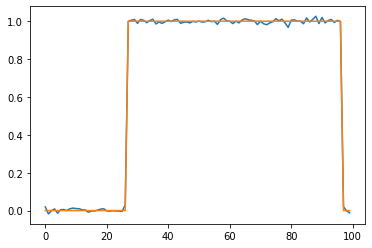

In [30]:
plt.plot(np_array)
plt.plot(np_array_mask)
plt.show()